# Natural Language Processing
## Fake News Detection 

In [62]:
# import libraries
#import ftfy
import nltk
import json
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import csv
import numpy as np
import nltk
import seaborn as sb
import warnings

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Binarizer


from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
#nltk.download('stopwords')


from wordcloud import STOPWORDS, WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.naive_bayes import GaussianNB

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier # need to import xboost calssifer

warnings.filterwarnings('ignore')
np.random.seed(0)

In [60]:
!pip install ftfy

     |████████████████████████████████| 71kB 3.8MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=f25bf305b6ffd3b75fc1e8c0d7dda9932a1d325d7c6db3edff3dcdb36b01ca62
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [61]:
import ftfy

In [3]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


# Loading the LIAR Dataset
The dataset is in the format of 3 tab seperated files. Loading it as a pandas dataframe. Combining the train, test and validation files to a single file so that we can do the train and test split as required.

In [5]:
# Importing the dataset
train = pd.read_csv('/drive/My Drive/Fake_News_Detection/train.tsv', delimiter='\t', quoting=3, header=None)
test = pd.read_csv('/drive/My Drive/Fake_News_Detection/test.tsv', delimiter='\t', quoting=3, header=None)
valid = pd.read_csv('/drive/My Drive/Fake_News_Detection/valid.tsv', delimiter='\t', quoting=3, header=None)

In [6]:
df_raw = pd.concat([train, test, valid], axis=0, sort=False)
df_raw = df_raw.sample(frac=1).reset_index()
df_raw.head(2)

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes


In [7]:
# The file contains 12836 rows and 15 columns
df_raw.shape

(12836, 15)

In [8]:
# naming the columns of the dataset
df_raw.columns=["index","ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]

In [9]:
df_raw.head(2)

,index,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes


In [10]:
# some of the statements
df_raw['statement'].head(10).tolist()

['"McCain opposes a woman\'s right to choose."',
 'The name Frank has risen in popularity by 20 percent since the debut of House of Cardson Netflix.',
 'Says Ted Cruz never denied his father was photographedwith Lee Harvey Oswald.',
 'Its been 14 years since a president or a vice president or a member of their family has not gone and attended at least an event at the Olympics.',
 'In the year 2013, the Obama administration released 104,000 criminal illegal aliens. They released 196 murderers people with homicide convictions, who are here illegally.',
 'Says the United States does not trade as much as other developed nations.',
 '"Oil companies ...currently have 68-million acres that they\'re not using."',
 'Says 24 million people in this country cant find a full-time job, 50 million cant see a doctor when theyre sick, 47 million people need government help to feed themselves and 15 million families owe more than the value of their home.',
 'President Obama went around the world and apo

In [11]:
# some of the speakers
df_raw['speaker'].head(20).tolist()

['moveon',
 'matt-lauer',
 'donald-trump',
 'candy-crowley',
 'ted-cruz',
 'rob-portman',
 'barack-obama',
 'alan-grayson',
 'mitt-romney',
 'joe-biden',
 'ellen-rosenblum',
 'linda-finn',
 'us-chamber-commerce',
 'tom-barrett',
 'chris-christie',
 'russell-edwards',
 'mitt-romney',
 'jeff-merkley',
 'rush-limbaugh',
 'john-boehner']

# Exploratory Data Analysis

Text(0.5, 1.0, 'Types & Number of Classes in the dataset')

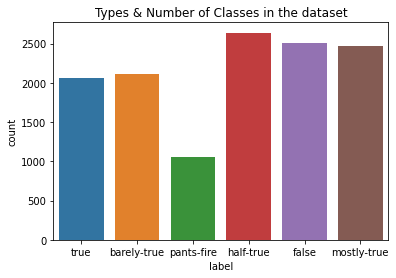

In [12]:
sns.countplot(x='label',data=df_raw)
plt.title('Types & Number of Classes in the dataset')

### Converting multiclass labels to two classes - Fake and True for exploratory data analysis

In [14]:
#function for mapping labels "true, mostly-true, half-true" to TRUE and "false, barely-true, pants-fire" to FAKE.
def binary_class_dataset(data):
    
    data = data.iloc[:, [2, 3]]
    data.columns = ['label', 'statement']
    Original_labels = {
        'true': 'True',
        'mostly-true': 'True',
        'half-true': 'True',
        'false': 'Fake',
        'barely-true': 'Fake',
        'pants-fire': 'Fake'
    }
    data['label'] = data['label'].map(Original_labels)

    return data

In [15]:
# running the function on the loaded dataframe
bi_class= binary_class_dataset(df_raw)

In [16]:
# new dataset with binary class labels - True and Fake substituted for the originals labels

bi_class.head(2)

,label,statement
0,True,"""McCain opposes a woman's right to choose."""
1,Fake,The name Frank has risen in popularity by 20 p...


## Creating Word Clouds for the text 'statements' in the LIAR dataset

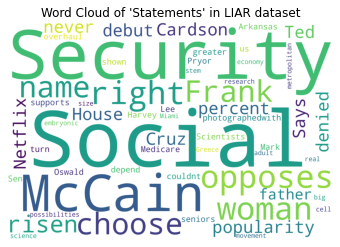

In [17]:
np.random.seed(0) # setting seed to get similar results over multiple experiments.

# word cloud for all the statements in the entire dataset
text = bi_class['statement'].values
wordcloud = WordCloud(width=3000, height=2000, background_color='white',stopwords=STOPWORDS).generate(str(text))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Word Cloud of 'Statements' in LIAR dataset")
plt.show()

In [18]:
# creating two dataset consisting of True and Fake statements seperately
np.random.seed(0)
true_statements_dataset = bi_class[bi_class['label'].astype(str) == 'True']
fake_statements_dataset = bi_class[bi_class['label'].astype(str) == 'Fake']

In [19]:
np.random.seed(0)
# contains only TRUE statements
true_statements_dataset.head(5)

,label,statement
0,True,"""McCain opposes a woman's right to choose."""
3,True,Its been 14 years since a president or a vice ...
4,True,"In the year 2013, the Obama administration rel..."
5,True,Says the United States does not trade as much ...
7,True,Says 24 million people in this country cant fi...


In [20]:
# contains only FAKE statements
np.random.seed(0)
fake_statements_dataset.head(5)

,label,statement
1,Fake,The name Frank has risen in popularity by 20 p...
2,Fake,Says Ted Cruz never denied his father was phot...
6,Fake,"""Oil companies ...currently have 68-million ac..."
8,Fake,President Obama went around the world and apol...
12,Fake,The new health care law crushes small business...


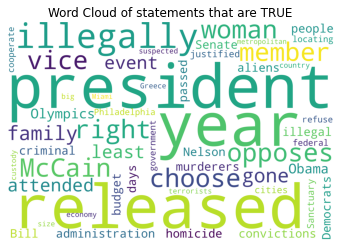

In [21]:
np.random.seed(0)
# creating word cloud for only those statements that are TRUE
text_true = true_statements_dataset['statement'].values
wordcloud_true = WordCloud(width=3000, height=2000, background_color='white',stopwords=STOPWORDS).generate(str(text_true))
plt.imshow(wordcloud_true)
plt.axis('off')
plt.title("Word Cloud of statements that are TRUE")
plt.show()

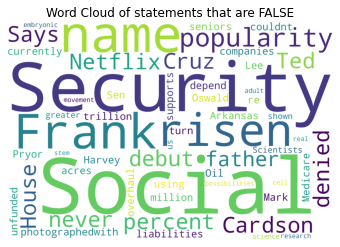

In [22]:
np.random.seed(0)
# creating word cloud for or only those statements that are FAKE
text_false = fake_statements_dataset['statement'].values
wordcloud_false = WordCloud(width=3000, height=2000, background_color='white',stopwords=STOPWORDS).generate(str(text_false))
plt.imshow(wordcloud_false)
plt.axis('off')
plt.title("Word Cloud of statements that are FALSE")
plt.show()

### Exploring the 'speakers' who have given the statements in the LIAR dataset

In [30]:
"""finding the total number of unique 'speakers' in the LIAR dataset"""
speakers_data = df_raw.copy()
speakers = speakers_data['speaker'].unique()

print("The total number of speakers in the LIAR dataset is : %d  " % len(speakers))
print()
print("Some sample speakers are:\n", speakers[:10].tolist())

The total number of speakers in the LIAR dataset is : 3318  

Some sample speakers are:
 ['moveon', 'matt-lauer', 'donald-trump', 'candy-crowley', 'ted-cruz', 'rob-portman', 'barack-obama', 'alan-grayson', 'mitt-romney', 'joe-biden']


In [31]:

""""displaying all the speakers in exploratory plot will not be possible nor meaningful.
            Hence finding the top speakers who have made frequent statements"""

speakers_cts = speakers_data.groupby("speaker").statement.count()
speakers = speakers_cts[speakers_cts > 100] # speakers who have made more than 100 statements.
print("There are %d speakers who have made statements more than 50 times in the dataset" % len(speakers))
print()
print("Some of the speakers and the number of statements made by them are:\n", speakers[:10])

There are 13 speakers who have made statements more than 50 times in the dataset

Some of the speakers and the number of statements made by them are:
 speaker
barack-obama       616
bernie-s           107
chain-email        178
chris-christie     105
donald-trump       344
hillary-clinton    297
john-mccain        189
marco-rubio        153
mitt-romney        216
rick-perry         173
Name: statement, dtype: int64


In [32]:
#Limiting ourselves to only prominent speakers for visualization
speakers_data = speakers_data[speakers_data['speaker'].isin(speakers.keys())]

In [33]:
"""function to groupby the speakers by the class and count of statements spoken by them"""

def class_counts(data, column):
    return data.groupby([column,"label"]).agg({"ID" : "count"})


#### Plot of top 13 speakers in the LIAR dataset labelled by class and count of statements they have given.

Text(0.5, 1.0, 'Top 13 speakers in the LIAR dataset with count and class of statements made')

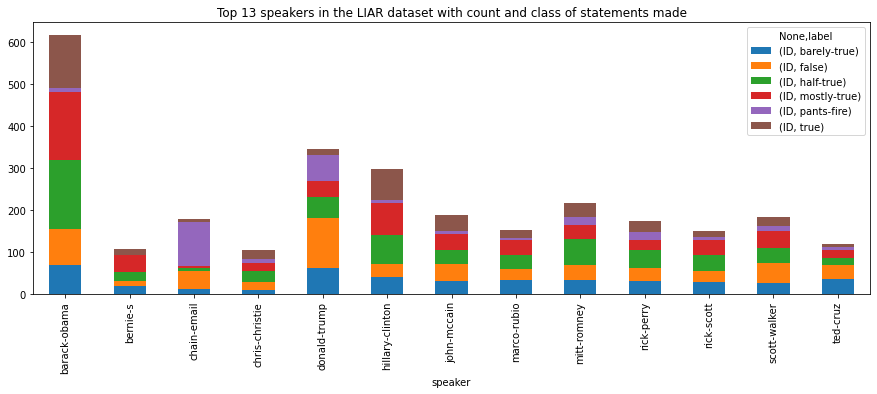

In [36]:
# stacked bar plot of speakrs with class and count of statements
breakdown = class_counts(speakers_data, 'speaker')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))
plt.title("Top 13 speakers in the LIAR dataset with count and class of statements made")

In [37]:
# Function for Normalising the statements and the speakers for comparison purpose

def normalize(data, column):
    norm = data.reset_index()
    norm = norm.set_index([column,'label'])['ID'].unstack(fill_value=0)

    row_totals = norm.sum(axis=1)
    for row in range(len(norm.index)):
        norm.iloc[row]/= row_totals[row]

    norm = norm.stack().reset_index(name='Percent').set_index([column, 'label'])
    return norm

#### Normalised plot of top 13 speakers in the LIAR dataset labelled type of statements they have given (for comparison)

Text(0.5, 1.0, 'Top 13 speakers in the LIAR dataset with count and class of statements made by them')

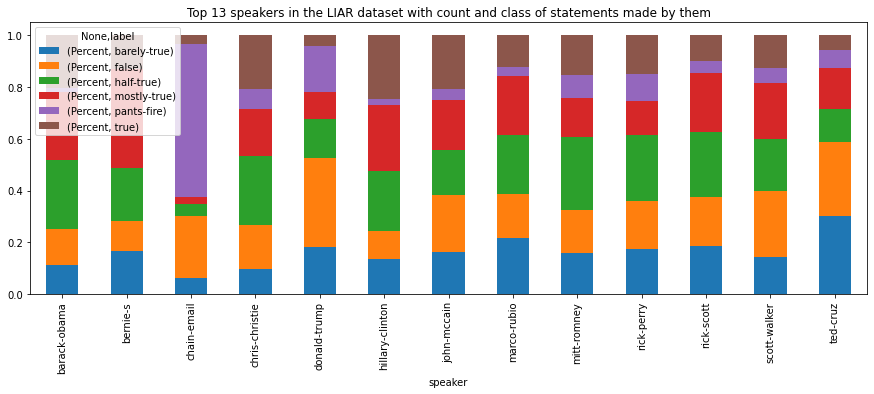

In [38]:
normalised_data = normalize(breakdown, 'speaker')
normalised_data.unstack().plot(kind='bar', stacked=True, figsize=(15,5))
plt.title("Top 13 speakers in the LIAR dataset with count and class of statements made by them")

From the above plot it can be seen that Facebook posts, Chain emails and Donald Trump have relatively higher number of 'pant-on_fire' fake statements compared to other speakers. We can also note that even though Obama made highest number of statements, his pant-on-fire statements are almost nill.

### Exploring the parties who have given statements in the LIAR dataset

In [39]:
# finding total number of parties in the LIAR dataset
parties_data = df_raw.copy()
parties = parties_data['party'].unique()
print("The total number of parties in LIAR dataset are : %d" % len(parties))
print()
print("Some  parties are:\n", parties.tolist())

The total number of parties in LIAR dataset are : 24

Some  parties are:
 ['democrat', 'none', 'republican', 'organization', 'journalist', 'newsmaker', 'independent', 'libertarian', 'state-official', 'columnist', 'activist', 'tea-party-member', 'labor-leader', 'talk-show-host', 'ocean-state-tea-party-action', 'business-leader', 'county-commissioner', 'constitution-party', 'government-body', 'education-official', 'democratic-farmer-labor', 'green', 'Moderate', 'liberal-party-canada']


In [40]:
# limiting the parties to those which have made frequent statements in the dataset.
parties_count = parties_data.groupby("party").statement.count()
parties = parties_count[parties_count > 20]     # more than 20 statements

print("Number of parties or entities who have made more than 20 statements in the LIAR dataset : %d" % len(parties))
print()
print("Some of the parties and number of statements made by them are :\n", parties[:10])

Number of parties or entities who have made more than 20 statements in the LIAR dataset : 12

Some of the parties and number of statements made by them are :
 party
activist          47
columnist         45
democrat        4150
independent      182
journalist        49
libertarian       51
newsmaker         66
none            2185
organization     265
republican      5687
Name: statement, dtype: int64


In [41]:
## Limiting ourselves to the top 12 parties in the LIAR dataset

parties_data = parties_data[parties_data['party'].isin(parties.keys())]

####  Plot of top 12 parties in the LIAR dataset labelled type of statements they have given

Text(0.5, 1.0, 'Top 12 parties/entities in the LIAR dataset with count and class of statements made by them')

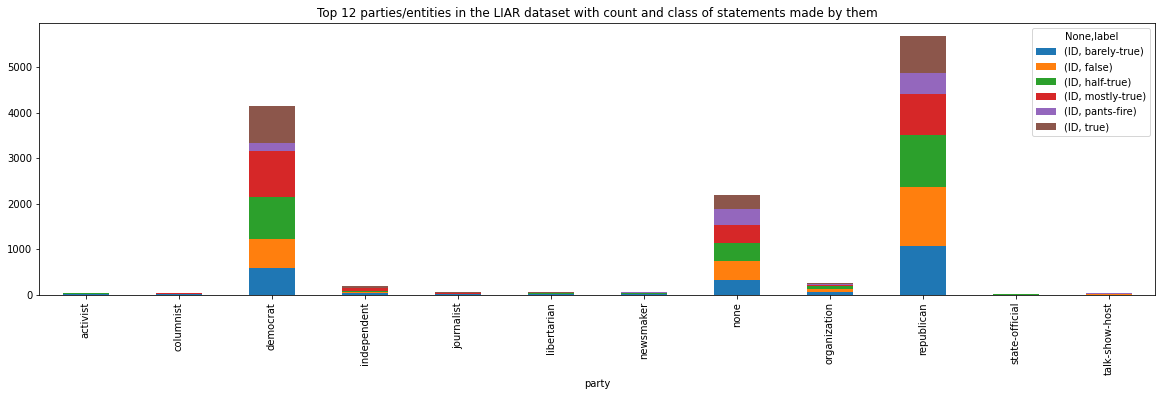

In [42]:
breakdown = class_counts(parties_data, 'party')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(20,5))
plt.title("Top 12 parties/entities in the LIAR dataset with count and class of statements made by them")

#### Normalised plot of top 12 parties in the LIAR dataset labelled type of statements they have given (for comparison)

Text(0.5, 1.0, 'Top 12 parties/entities in the LIAR dataset with count and class of statements made by them')

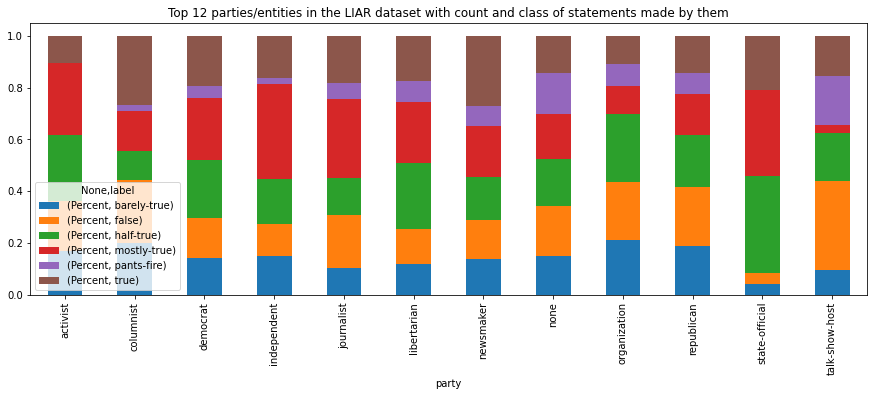

In [43]:
normalized_data = normalize(breakdown, 'party')
normalized_data.unstack().plot(kind='bar', stacked=True, figsize=(15,5))
plt.title("Top 12 parties/entities in the LIAR dataset with count and class of statements made by them")

# Using CountVectorizer for Extracting features from 'statements' in LIAR dataset

In [44]:
# specifying features and labels
X= df_raw['statement']
y=df_raw['label']

In [45]:
# sample statements
X.head(5).tolist()

['"McCain opposes a woman\'s right to choose."',
 'The name Frank has risen in popularity by 20 percent since the debut of House of Cardson Netflix.',
 'Says Ted Cruz never denied his father was photographedwith Lee Harvey Oswald.',
 'Its been 14 years since a president or a vice president or a member of their family has not gone and attended at least an event at the Olympics.',
 'In the year 2013, the Obama administration released 104,000 criminal illegal aliens. They released 196 murderers people with homicide convictions, who are here illegally.']

In [46]:
#sample labels
y.head(5)

0           true
1    barely-true
2     pants-fire
3           true
4      half-true
Name: label, dtype: object

In [57]:
# specifying train and test split with ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

10268 2568
10268 2568


### Custom Pre - Processing and Tokenisation of the data

In [52]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [53]:

""" Regular expression for cleaning the statements"""

hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")
extras_re = re.compile("[.;:!\'?,\"()\[\]]")
#apos_re = "\'[a-z]*"
#leftover_re = "\S+"

""" Preprocessing the text in the statements"""
def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = extras_re.sub("",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

# regular expression for custom tokenisation"
tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)

# defining 3 types of tokenisation

def custom_tokenise(text):
    return tokenise_re.findall(text.lower())

def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words


def nltk_twitter_tokenise(text):
    twtok = nltk.tokenize.TweetTokenizer()
    return twtok.tokenize(text.lower())

# stop words list set to english
stopwords_list = stopwords.words('english') # stop word list



""" function for decontracting the statements"""
#def decontracted(phrase):
   # phrase = re.sub(r"won\'t", "will not", phrase)
   # phrase = re.sub(r"can\'t", "can not", phrase)
   # phrase = re.sub(r"n\'t", " not", phrase)
   # phrase = re.sub(r"\'re", " are", phrase)
   # phrase = re.sub(r"\'s", " is", phrase)
   # phrase = re.sub(r"\'d", " would", phrase)
    #phrase = re.sub(r"\'ll", " will", phrase)
    #phrase = re.sub(r"\'t", " not", phrase)
    #phrase = re.sub(r"\'ve", " have", phrase)
   # phrase = re.sub(r"\'m", " am", phrase)
    #return phrase

' function for decontracting the statements'

### Defining custom functions for displaying results of Classification

In [54]:
# function for results of cross-validation
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))


# fucntion for results of model fitting
def print_scores():
    print("Accuracy: ", accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    
# function for displaying confusion matrix
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (10, 8)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="BuPu", center=0, fmt='g')
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

# function for displaying confusion matrix in percentage terms
def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0)*100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="PiYG", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    
#list(df_columns.columns))-list(df_raw['labels'])"coolwarm"'Blues'PiYG'BuPu'

## Creating Pipeline with CountVectorizer with Custom preprocessing, Tokenisation, Stopwords, Normalistion (using TFIDTransformer), Feature selection and Logistic regression classifier

In [55]:
model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list)),
    ('norm2', TfidfTransformer(norm=None)),
    ('selector', SelectKBest(chi2, k=1000)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [63]:
# fitting the model
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores() # using the predefined function to display results of the classification

Accuracy:  0.24143302180685358
              precision    recall  f1-score   support

 barely-true       0.25      0.17      0.20       422
       false       0.22      0.40      0.28       502
   half-true       0.24      0.25      0.25       528
 mostly-true       0.26      0.25      0.25       493
  pants-fire       0.32      0.15      0.20       210
        true       0.26      0.15      0.19       413

    accuracy                           0.24      2568
   macro avg       0.26      0.23      0.23      2568
weighted avg       0.25      0.24      0.23      2568

[[ 70 163  85  64  17  23]
 [ 59 202 109  76  18  38]
 [ 60 172 134  94  15  53]
 [ 31 159 120 121   9  53]
 [ 28  84  39  19  31   9]
 [ 29 146  75  93   8  62]]


In [64]:
# limiting the max features to 1000 and checking the model
model.set_params(vectorizer__max_features=1000)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=1000, min_df=1,
                                 ngram_range=(1, 1),
                                 preprocessor=<function preprocess at 0x7fe52d2b1b90>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'oursel...
                                  sublinear_tf=False, use_idf=True)),
                ('selector',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x7fe53b681710>)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
       

In [65]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()
# the accuracy is reduced so reverting back without setting max features

Accuracy:  0.23870716510903428
              precision    recall  f1-score   support

 barely-true       0.23      0.20      0.22       422
       false       0.25      0.30      0.27       502
   half-true       0.24      0.24      0.24       528
 mostly-true       0.27      0.27      0.27       493
  pants-fire       0.19      0.17      0.18       210
        true       0.21      0.21      0.21       413

    accuracy                           0.24      2568
   macro avg       0.23      0.23      0.23      2568
weighted avg       0.24      0.24      0.24      2568

[[ 84 113  79  62  29  55]
 [ 70 149  92  71  48  72]
 [ 71 103 125 107  36  86]
 [ 63  86  91 132  22  99]
 [ 32  58  45  21  36  18]
 [ 39  87  90  88  22  87]]


#### Using Binarizer for normalisation instead of TfidfTransformer (i.e. scale to 0 for not present or 1 for present at any frequency), this is useful when documents are shorts as 'statements' in LIAR dataset

In [67]:

model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list)),
    ('norm', Binarizer()),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [68]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()


Accuracy:  0.2472741433021807
              precision    recall  f1-score   support

 barely-true       0.25      0.23      0.24       422
       false       0.24      0.28      0.26       502
   half-true       0.27      0.30      0.28       528
 mostly-true       0.25      0.25      0.25       493
  pants-fire       0.24      0.14      0.17       210
        true       0.23      0.21      0.22       413

    accuracy                           0.25      2568
   macro avg       0.24      0.23      0.24      2568
weighted avg       0.25      0.25      0.25      2568

[[ 98 100  94  60  23  47]
 [ 82 140  96  89  28  67]
 [ 67 100 157 103  19  82]
 [ 71  98 108 123   8  85]
 [ 41  57  46  21  29  16]
 [ 35  88  83 104  15  88]]


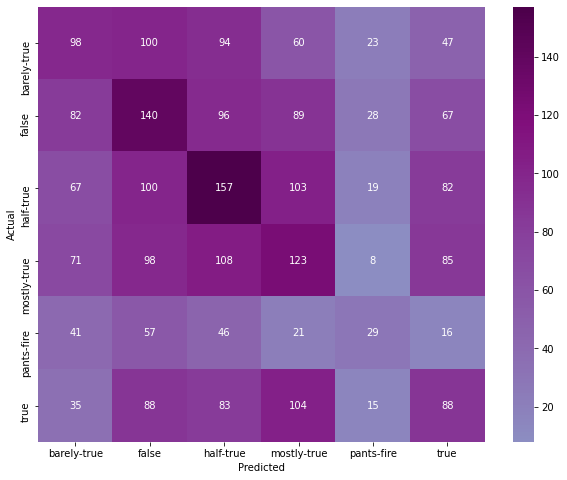

In [69]:
confusion_matrix_heatmap(confusion_matrix(y_test,predictions), model.classes_)

In [70]:
# code to view the selected features
vectorizer = CountVectorizer(analyzer='word')
selector = SelectKBest(chi2, k=100)
feats = vectorizer.fit_transform(X_train)
filtered = selector.fit_transform(feats, y_train)

In [71]:
from itertools import compress
cols = selector.get_support()
names = vectorizer.get_feature_names()

print(list(compress(names,cols)))

['000', '10', '247', 'and', 'average', 'bachmann', 'barack', 'beliefs', 'blue', 'border', 'bulbs', 'care', 'country', 'cross', 'cut', 'debunked', 'duffy', 'face', 'georgia', 'gov', 'half', 'hillary', 'in', 'increased', 'jersey', 'jobs', 'kenyan', 'kloppenburgs', 'landrieu', 'last', 'less', 'lowest', 'lying', 'mcauliffe', 'mccain', 'meat', 'michelle', 'million', 'monument', 'more', 'mormon', 'muslim', 'muslims', 'nose', 'obama', 'obamacare', 'obamas', 'of', 'ops', 'oswald', 'outbreak', 'outlaws', 'percent', 'photographed', 'plan', 'poverty', 'president', 'prisons', 'protein', 'radar', 'rate', 'rep', 'reps', 'retiree', 'richest', 'riot', 'rugs', 'says', 'scheme', 'scott', 'sean', 'sharia', 'sic', 'since', 'socialists', 'society', 'spending', 'sporting', 'states', 'stimulus', 'supports', 'takeover', 'than', 'the', 'three', 'to', 'today', 'top', 'transactions', 'unelected', 'walker', 'wash', 'we', 'wic', 'will', 'wisconsin', 'wording', 'words', 'year', 'your']


In [72]:
# Using Multinomial Naive Bayes classifier
model.set_params(clf=MultinomialNB())

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1),
                                 preprocessor=<function preprocess at 0x7fe52d2b1b90>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'oursel...
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
  

In [73]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.24805295950155765
              precision    recall  f1-score   support

 barely-true       0.23      0.21      0.22       422
       false       0.23      0.23      0.23       502
   half-true       0.25      0.36      0.29       528
 mostly-true       0.27      0.33      0.30       493
  pants-fire       0.30      0.08      0.13       210
        true       0.24      0.15      0.18       413

    accuracy                           0.25      2568
   macro avg       0.25      0.23      0.23      2568
weighted avg       0.25      0.25      0.24      2568

[[ 90  93 122  73  12  32]
 [ 84 117 140 100  12  49]
 [ 70  93 191 115  10  49]
 [ 62  73 144 161   3  50]
 [ 43  60  54  24  17  12]
 [ 36  68 125 120   3  61]]


In [74]:
# Fitting C-Support Vector Classifier
model.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.23325545171339565
              precision    recall  f1-score   support

 barely-true       0.20      0.25      0.22       422
       false       0.24      0.28      0.26       502
   half-true       0.27      0.27      0.27       528
 mostly-true       0.25      0.22      0.23       493
  pants-fire       0.21      0.16      0.18       210
        true       0.22      0.17      0.19       413

    accuracy                           0.23      2568
   macro avg       0.23      0.22      0.23      2568
weighted avg       0.23      0.23      0.23      2568

[[104 108  88  51  26  45]
 [117 141  74  74  39  57]
 [105  94 141  93  31  64]
 [ 94  98 107 109  11  74]
 [ 53  58  33  18  33  15]
 [ 59  98  80  90  15  71]]


In [75]:
# fitting Decision tree classifier
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
model.set_params(clf=decision_tree)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.23208722741433022
              precision    recall  f1-score   support

 barely-true       0.20      0.18      0.19       422
       false       0.27      0.32      0.30       502
   half-true       0.24      0.24      0.24       528
 mostly-true       0.24      0.25      0.25       493
  pants-fire       0.15      0.13      0.14       210
        true       0.21      0.20      0.20       413

    accuracy                           0.23      2568
   macro avg       0.22      0.22      0.22      2568
weighted avg       0.23      0.23      0.23      2568

[[ 76 103  91  72  28  52]
 [ 80 162  88  77  36  59]
 [ 67 111 126 108  36  80]
 [ 60  99  89 124  27  94]
 [ 36  49  37  39  27  22]
 [ 55  71  90  91  25  81]]


In [76]:
# fitting Random forest classifier
model.set_params(clf=RandomForestClassifier(random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.25272585669781933
              precision    recall  f1-score   support

 barely-true       0.24      0.14      0.18       422
       false       0.25      0.44      0.32       502
   half-true       0.26      0.26      0.26       528
 mostly-true       0.26      0.29      0.27       493
  pants-fire       0.42      0.10      0.17       210
        true       0.21      0.15      0.18       413

    accuracy                           0.25      2568
   macro avg       0.27      0.23      0.23      2568
weighted avg       0.26      0.25      0.24      2568

[[ 59 149  99  75   7  33]
 [ 50 223  94  73  10  52]
 [ 56 146 139 120   6  61]
 [ 35 132 100 142   6  78]
 [ 25  85  38  27  22  13]
 [ 24 146  70 107   2  64]]


In [77]:
# fitting X-gradient boost algorithm
model.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.23870716510903428
              precision    recall  f1-score   support

 barely-true       0.21      0.11      0.15       422
       false       0.23      0.43      0.30       502
   half-true       0.25      0.29      0.27       528
 mostly-true       0.24      0.26      0.25       493
  pants-fire       0.29      0.05      0.09       210
        true       0.24      0.13      0.17       413

    accuracy                           0.24      2568
   macro avg       0.24      0.21      0.20      2568
weighted avg       0.24      0.24      0.22      2568

[[ 47 159 106  81   6  23]
 [ 49 218 104  88   9  34]
 [ 51 161 152 106   8  50]
 [ 30 139 128 130   2  64]
 [ 25 111  34  25  11   4]
 [ 20 142  85 109   2  55]]


## Cross validating the best models from CountVectorizer Pipeline - Logistic regression and Multinomial Guassian NB

In [ ]:
model.set_params(clf= LogisticRegression(solver='liblinear', random_state=0))

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function preprocess a...nalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [ ]:

cv_scores = cross_validate(model, X, y, 
                           cv=StratifiedKFold(n_splits=5, random_state=0), 
                           return_train_score=False, 
                           scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
                          )

In [ ]:
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

Accuracy: mean = 24.19%, sd = 1.05%, min = 22.96, max = 25.55
Precision: mean = 24.19%, sd = 1.03%, min = 22.94, max = 25.50
Recall: mean = 24.19%, sd = 1.05%, min = 22.96, max = 25.55
F1: mean = 23.98%, sd = 1.05%, min = 22.81, max = 25.35


In [ ]:
model.set_params(clf=MultinomialNB())

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function preprocess a...zer(copy=True, threshold=0.0)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [ ]:
cv_scores = cross_validate(model, X, y, 
                           cv=StratifiedKFold(n_splits=5, random_state=0), 
                           return_train_score=False, 
                           scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
                          )

In [ ]:
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

Accuracy: mean = 24.28%, sd = 0.63%, min = 23.56, max = 25.22
Precision: mean = 24.43%, sd = 0.77%, min = 23.36, max = 25.20
Recall: mean = 24.28%, sd = 0.63%, min = 23.56, max = 25.22
F1: mean = 23.38%, sd = 0.63%, min = 22.68, max = 24.33


### Replacing 'word' with char_wb(which counts characters within words) and ngrams range of 1-3 in the pipeline.

In [ ]:
model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char_wb',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list, ngram_range=(1,3))),
    ('norm', Binarizer()),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [ ]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()



Accuracy:  0.21378504672897197
              precision    recall  f1-score   support

 barely-true       0.18      0.18      0.18       422
       false       0.22      0.24      0.23       502
   half-true       0.25      0.26      0.25       528
 mostly-true       0.24      0.25      0.25       493
  pants-fire       0.15      0.12      0.13       210
        true       0.19      0.17      0.18       413

   micro avg       0.21      0.21      0.21      2568
   macro avg       0.20      0.20      0.20      2568
weighted avg       0.21      0.21      0.21      2568

[[ 77  87 100  74  31  53]
 [105 119  87  77  48  66]
 [ 82  97 136 103  25  85]
 [ 72  79 115 121  22  84]
 [ 39  57  41  27  26  20]
 [ 56  93  75  92  27  70]]


In [ ]:
model.set_params(clf=MultinomialNB())
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()


Accuracy:  0.24182242990654207
              precision    recall  f1-score   support

 barely-true       0.22      0.21      0.22       422
       false       0.24      0.28      0.26       502
   half-true       0.28      0.23      0.25       528
 mostly-true       0.26      0.27      0.26       493
  pants-fire       0.20      0.25      0.22       210
        true       0.24      0.20      0.22       413

   micro avg       0.24      0.24      0.24      2568
   macro avg       0.24      0.24      0.24      2568
weighted avg       0.24      0.24      0.24      2568

[[ 89 107  67  74  47  38]
 [ 81 140  76  77  71  57]
 [ 76 104 122 117  41  68]
 [ 65  93  83 134  31  87]
 [ 40  58  24  18  53  17]
 [ 48  90  63 102  27  83]]


In [ ]:
model.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.2044392523364486
              precision    recall  f1-score   support

 barely-true       0.16      0.23      0.19       422
       false       0.23      0.25      0.24       502
   half-true       0.24      0.23      0.23       528
 mostly-true       0.23      0.19      0.21       493
  pants-fire       0.15      0.14      0.15       210
        true       0.19      0.14      0.16       413

   micro avg       0.20      0.20      0.20      2568
   macro avg       0.20      0.20      0.20      2568
weighted avg       0.21      0.20      0.20      2568

[[ 96  98  84  73  36  35]
 [135 126  74  69  45  53]
 [121 104 121  85  32  65]
 [102  92 106  95  26  72]
 [ 57  51  35  22  30  15]
 [ 79  89  89  70  29  57]]


In [ ]:
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
model.set_params(clf=decision_tree)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.2091121495327103
              precision    recall  f1-score   support

 barely-true       0.18      0.19      0.18       422
       false       0.26      0.26      0.26       502
   half-true       0.24      0.24      0.24       528
 mostly-true       0.20      0.21      0.21       493
  pants-fire       0.10      0.10      0.10       210
        true       0.20      0.18      0.19       413

   micro avg       0.21      0.21      0.21      2568
   macro avg       0.20      0.20      0.20      2568
weighted avg       0.21      0.21      0.21      2568

[[ 79  75  89  82  39  58]
 [ 80 132 100  93  41  56]
 [108  92 128  98  28  74]
 [ 81  88  90 105  43  86]
 [ 41  39  49  43  20  18]
 [ 57  82  77  93  31  73]]


In [ ]:
model.set_params(clf=RandomForestClassifier(random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.21456386292834892
              precision    recall  f1-score   support

 barely-true       0.21      0.28      0.24       422
       false       0.20      0.28      0.24       502
   half-true       0.21      0.24      0.22       528
 mostly-true       0.24      0.20      0.22       493
  pants-fire       0.21      0.05      0.08       210
        true       0.22      0.13      0.16       413

   micro avg       0.21      0.21      0.21      2568
   macro avg       0.22      0.20      0.19      2568
weighted avg       0.22      0.21      0.21      2568

[[119 126  87  61   6  23]
 [121 141 113  67  18  42]
 [ 99 143 125 102   9  50]
 [ 88 120 122 101   6  56]
 [ 48  60  44  29  11  18]
 [ 88 102  97  69   3  54]]


In [ ]:
model.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.2542834890965732
              precision    recall  f1-score   support

 barely-true       0.25      0.15      0.19       422
       false       0.25      0.43      0.32       502
   half-true       0.27      0.34      0.30       528
 mostly-true       0.24      0.26      0.25       493
  pants-fire       0.21      0.04      0.07       210
        true       0.26      0.15      0.19       413

   micro avg       0.25      0.25      0.25      2568
   macro avg       0.25      0.23      0.22      2568
weighted avg       0.25      0.25      0.24      2568

[[ 63 126 125  80   8  20]
 [ 52 215  97  87  15  36]
 [ 46 145 177 106   5  49]
 [ 42 140 121 126   4  60]
 [ 29  87  42  33   9  10]
 [ 25 133  94  96   2  63]]


## Grid search CV with top_k from chi squared feature selection set to different values and top 2 performing classifiers with CountVectorizer 

In [ ]:
model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list, ngram_range=(1,3))),
    ('norm', Binarizer()),
    ('selector', SelectKBest(score_func = chi2)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

search = GridSearchCV(model, cv=StratifiedKFold(n_splits=5, random_state=0), 
                      return_train_score=False, 
                      scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid={
                          'selector__k': [10, 50, 100, 250, 500, 1000],
                          'clf': [MultinomialNB(), XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0)],
                      })

search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3),
        preprocessor=<function preprocess a...nalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selector__k': [10, 50, 100, 250, 500, 1000], 'clf': [MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_we...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       si

In [ ]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_selector__k,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,5.066205,0.107881,4.470505,0.012073,"MultinomialNB(alpha=1.0, class_prior=None, fit...",10,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.210219,0.204966,0.212756,...,0.005313,11,0.146366,0.117305,0.148734,0.139070,0.162499,0.142792,0.014830,11
1,5.265847,0.347337,4.834284,0.716322,"MultinomialNB(alpha=1.0, class_prior=None, fit...",50,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.217518,0.215190,0.220545,...,0.005010,10,0.177294,0.177779,0.179298,0.184101,0.190455,0.181783,0.004958,9
2,5.051118,0.086565,4.610430,0.242156,"MultinomialNB(alpha=1.0, class_prior=None, fit...",100,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.217032,0.205453,0.223953,...,0.009590,9,0.196841,0.171910,0.202899,0.196349,0.204892,0.194576,0.011813,5
3,5.571449,0.207332,4.945372,0.170043,"MultinomialNB(alpha=1.0, class_prior=None, fit...",250,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.218005,0.208374,0.223466,...,0.009709,8,0.194495,0.172376,0.210059,0.196029,0.199171,0.194425,0.012295,6
4,5.331514,0.150665,4.697368,0.205673,"MultinomialNB(alpha=1.0, class_prior=None, fit...",500,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.222384,0.232230,0.234177,...,0.005406,4,0.206567,0.219778,0.227306,0.223806,0.212865,0.218064,0.007492,3
5,5.135728,0.122961,4.555354,0.081240,"MultinomialNB(alpha=1.0, class_prior=None, fit...",1000,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.246715,0.241967,0.239533,...,0.003819,2,0.238117,0.234687,0.233107,0.233334,0.227087,0.233268,0.003571,1
6,6.896729,0.053180,4.968376,0.014739,"XGBClassifier(base_score=0.5, booster='gbtree'...",10,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.206813,0.205453,0.214216,...,0.003412,12,0.139372,0.117942,0.137553,0.140697,0.134278,0.133968,0.008299,12
7,7.517044,0.095601,4.986464,0.022308,"XGBClassifier(base_score=0.5, booster='gbtree'...",50,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.224818,0.219085,0.240019,...,0.007378,7,0.179077,0.164246,0.185533,0.183433,0.166620,0.175783,0.008735,10
8,8.069905,0.128869,4.982375,0.030587,"XGBClassifier(base_score=0.5, booster='gbtree'...",100,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.222871,0.221519,0.242454,...,0.007708,6,0.187396,0.180239,0.206881,0.192986,0.188731,0.191247,0.008830,8
9,8.889566,0.149069,4.968692,0.020292,"XGBClassifier(base_score=0.5, booster='gbtree'...",250,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.222871,0.221519,0.248783,...,0.009900,5,0.187396,0.180239,0.218803,0.192986,0.188731,0.193631,0.013240,7


Accuracy:  0.24104361370716512
              precision    recall  f1-score   support

 barely-true       0.26      0.20      0.22       422
       false       0.26      0.30      0.28       502
   half-true       0.22      0.32      0.26       528
 mostly-true       0.23      0.25      0.24       493
  pants-fire       0.31      0.11      0.16       210
        true       0.23      0.17      0.20       413

   micro avg       0.24      0.24      0.24      2568
   macro avg       0.25      0.22      0.23      2568
weighted avg       0.25      0.24      0.24      2568

[[ 83 115 105  75  13  31]
 [ 65 152 150  79  14  42]
 [ 68  89 168 119  11  73]
 [ 37  85 158 121   8  84]
 [ 30  67  62  16  23  12]
 [ 34  80 110 112   5  72]]


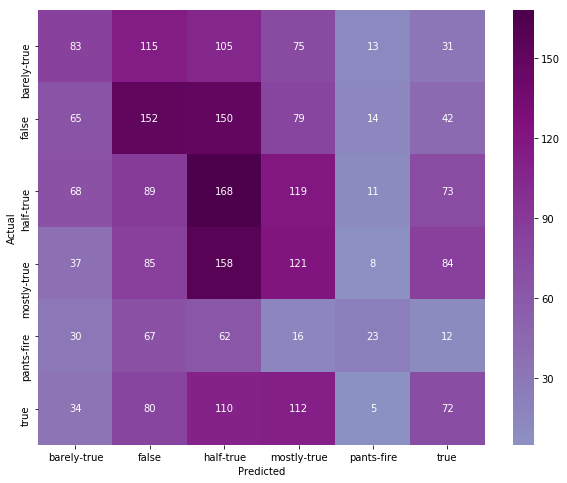

In [ ]:
# results of the best fit classifier
predictions = search.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(y_test,predictions), search.classes_)

In [ ]:
print(search.best_estimator_ )

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3),
        preprocessor=<function preprocess a...unction chi2 at 0x11afb8730>)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])


In [ ]:
search.best_score_

0.23326803598618945

In [ ]:
print(search.best_params_)

{'clf': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'selector__k': 1000}


In [ ]:
print(search.scorer_)

{'accuracy': make_scorer(accuracy_score), 'precision_weighted': make_scorer(precision_score, pos_label=None, average=weighted), 'recall_weighted': make_scorer(recall_score, pos_label=None, average=weighted), 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted)}


## Creating Pipeline with TFID Vectorizer along with Feature Union of 'total words' in the 'statements'


TF-IDF - stands for “Term Frequency — Inverse Document”. Term Frequency summarizes how often a given word appears within a document.Inverse Document Frequency scales words that appear a lot across documents.TF-IDF highlight words that are more interesting, e.g. frequent in a document but not across documents.

However in this instance we use feature union as well by incorporating the total words in each sentence as another feature. We build a custom transformer with two classes for features in the statements and the total number of words in the statements. By setting min\_df to 0.25 and max\_df to 0.75 we restrict the terms in the vocabulary based on document frequency

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.field]]

In [ ]:
df_raw_tfid= df_raw.copy()

In [ ]:
df_raw_tfid.head(2)

,index,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes


In [ ]:
header_list=["index","ID", "label", "statement","TotalWords","Lemmatised_words", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]

In [ ]:
df_raw_tfid = df_raw_tfid.reindex(columns = header_list) 

In [ ]:
# creating new column to hold total number of words in the statements and calculating the total words
df_raw_tfid['TotalWords'] = df_raw_tfid['statement'].str.split().str.len()

In [ ]:
df_raw_tfid.head(2)

,index,ID,label,statement,TotalWords,Lemmatised_words,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",7,NaN,abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,18,NaN,pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes


In [ ]:
X = df_raw_tfid[['statement', 'TotalWords']]

Y = df_raw_tfid['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

## Creating the pipeline with TFIDVectorizer and feature union of total words in statements

In [ ]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='word',preprocessor=preprocess, tokenizer=Tokenizer, stop_words=stopwords_list,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
    ])



In [ ]:
# logistic regression
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()



Accuracy:  0.2542848239326893
              precision    recall  f1-score   support

 barely-true       0.24      0.18      0.20       497
       false       0.28      0.39      0.32       644
   half-true       0.24      0.31      0.27       647
 mostly-true       0.25      0.30      0.28       629
  pants-fire       0.22      0.03      0.06       244
        true       0.26      0.15      0.19       548

   micro avg       0.25      0.25      0.25      3209
   macro avg       0.25      0.23      0.22      3209
weighted avg       0.25      0.25      0.24      3209

[[ 87 143 135  90   5  37]
 [ 56 248 168 104   7  61]
 [ 81 143 199 169   4  51]
 [ 53 142 163 190   6  75]
 [ 34 102  53  33   8  14]
 [ 46 121 127 163   7  84]]


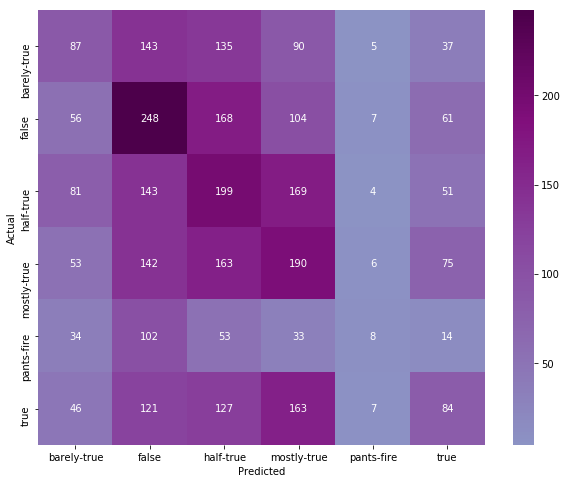

In [ ]:
confusion_matrix_heatmap(confusion_matrix(y_test, predictions), classifier.classes_)

In [ ]:
#becasue multinominal naive baiese deosnt fit
classifier.set_params(clf=GaussianNB())
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

Accuracy:  0.20878778435649736
              precision    recall  f1-score   support

 barely-true       0.23      0.11      0.15       497
       false       0.22      0.30      0.26       644
   half-true       0.26      0.13      0.17       647
 mostly-true       0.23      0.27      0.25       629
  pants-fire       0.12      0.30      0.17       244
        true       0.21      0.18      0.19       548

   micro avg       0.21      0.21      0.21      3209
   macro avg       0.21      0.21      0.20      3209
weighted avg       0.22      0.21      0.20      3209

[[ 54 130  55  99 101  58]
 [ 43 193  52 141 140  75]
 [ 44 192  83 138 100  90]
 [ 43 167  51 172  92 104]
 [ 22  55  23  37  72  35]
 [ 30 129  56 160  77  96]]


In [ ]:
classifier.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=1000))
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

Accuracy:  0.25771268307884077
              precision    recall  f1-score   support

 barely-true       0.24      0.19      0.21       497
       false       0.28      0.43      0.34       644
   half-true       0.24      0.31      0.27       647
 mostly-true       0.26      0.30      0.28       629
  pants-fire       0.00      0.00      0.00       244
        true       0.25      0.13      0.17       548

   micro avg       0.26      0.26      0.26      3209
   macro avg       0.21      0.23      0.21      3209
weighted avg       0.24      0.26      0.24      3209

[[ 94 150 129  89   1  34]
 [ 71 275 152  94   2  50]
 [ 87 152 200 162   1  45]
 [ 66 148 164 187   0  64]
 [ 30 111  60  27   0  16]
 [ 39 142 124 172   0  71]]


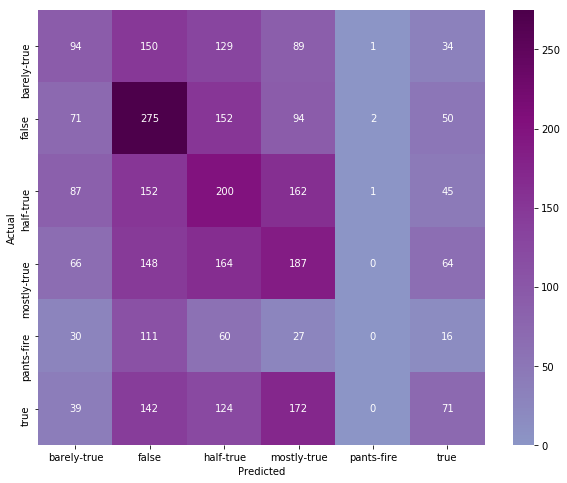

In [ ]:
#highest accuracy 
confusion_matrix_heatmap(confusion_matrix(y_test,predictions), classifier.classes_)

In [ ]:
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
classifier.set_params(clf=decision_tree)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

Accuracy:  0.20130881894671238
              precision    recall  f1-score   support

 barely-true       0.17      0.19      0.18       497
       false       0.23      0.22      0.23       644
   half-true       0.21      0.20      0.20       647
 mostly-true       0.23      0.23      0.23       629
  pants-fire       0.11      0.12      0.12       244
        true       0.21      0.20      0.20       548

   micro avg       0.20      0.20      0.20      3209
   macro avg       0.19      0.19      0.19      3209
weighted avg       0.20      0.20      0.20      3209

[[ 96 104  96  90  43  68]
 [122 143 106 122  55  96]
 [106 127 127 130  52 105]
 [124 106 116 143  40 100]
 [ 41  50  42  44  30  37]
 [ 85  94 114 104  44 107]]


In [ ]:
classifier.set_params(clf=RandomForestClassifier(random_state=1000))
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

Accuracy:  0.20598317232782798
              precision    recall  f1-score   support

 barely-true       0.16      0.23      0.19       497
       false       0.22      0.29      0.25       644
   half-true       0.20      0.22      0.21       647
 mostly-true       0.23      0.20      0.21       629
  pants-fire       0.13      0.05      0.07       244
        true       0.26      0.15      0.19       548

   micro avg       0.21      0.21      0.21      3209
   macro avg       0.20      0.19      0.19      3209
weighted avg       0.21      0.21      0.20      3209

[[114 143 108  91   8  33]
 [137 186 147 102  14  58]
 [160 167 145  99  20  56]
 [142 152 135 125  15  60]
 [ 46  72  55  42  11  18]
 [112 128 126  88  14  80]]


In [ ]:
classifier.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

Accuracy:  0.22904331567466502
              precision    recall  f1-score   support

 barely-true       0.21      0.17      0.19       497
       false       0.26      0.33      0.29       644
   half-true       0.24      0.30      0.26       647
 mostly-true       0.21      0.26      0.23       629
  pants-fire       0.22      0.06      0.09       244
        true       0.21      0.12      0.15       548

   micro avg       0.23      0.23      0.23      3209
   macro avg       0.22      0.21      0.20      3209
weighted avg       0.23      0.23      0.22      3209

[[ 86 133 123 109   9  37]
 [ 75 211 150 139  16  53]
 [ 84 123 192 180   8  60]
 [ 77 144 154 166  10  78]
 [ 30  88  54  38  14  20]
 [ 58 124 138 156   6  66]]


## Using char_wb for the TFIDVectorizer and features union

In [ ]:
classifier_char_wb = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='char_wb',preprocessor=preprocess, tokenizer=Tokenizer, stop_words=stopwords_list,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', LogisticRegression(solver='liblinear', random_state=1000)),
    ])

In [ ]:
#logistic regression
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

Accuracy:  0.24992209411031474
              precision    recall  f1-score   support

 barely-true       0.23      0.17      0.19       497
       false       0.26      0.35      0.30       644
   half-true       0.25      0.35      0.29       647
 mostly-true       0.26      0.29      0.27       629
  pants-fire       0.07      0.01      0.01       244
        true       0.26      0.15      0.19       548

   micro avg       0.25      0.25      0.25      3209
   macro avg       0.22      0.22      0.21      3209
weighted avg       0.24      0.25      0.24      3209

[[ 84 142 132  92   7  40]
 [ 79 225 162 106  10  62]
 [ 73 138 225 154   4  53]
 [ 61 147 171 185   0  65]
 [ 35  90  72  32   2  13]
 [ 35 132 138 156   6  81]]


In [ ]:
# Gaussian NB
classifier_char_wb.set_params(clf=GaussianNB())
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

Accuracy:  0.22655032720473667
              precision    recall  f1-score   support

 barely-true       0.20      0.18      0.19       497
       false       0.25      0.23      0.24       644
   half-true       0.26      0.26      0.26       647
 mostly-true       0.25      0.24      0.24       629
  pants-fire       0.15      0.26      0.19       244
        true       0.22      0.20      0.21       548

   micro avg       0.23      0.23      0.23      3209
   macro avg       0.22      0.23      0.22      3209
weighted avg       0.23      0.23      0.23      3209

[[ 91  92  93  83  71  67]
 [ 95 145 109 106  92  97]
 [ 98 114 169 118  63  85]
 [ 88  91 123 150  70 107]
 [ 31  58  44  22  63  26]
 [ 51  90 110 125  63 109]]


In [ ]:
#Support vector Machine classifier
classifier_char_wb.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

Accuracy:  0.24992209411031474
              precision    recall  f1-score   support

 barely-true       0.25      0.20      0.22       497
       false       0.24      0.35      0.29       644
   half-true       0.26      0.37      0.30       647
 mostly-true       0.25      0.26      0.26       629
  pants-fire       0.00      0.00      0.00       244
        true       0.25      0.13      0.17       548

   micro avg       0.25      0.25      0.25      3209
   macro avg       0.21      0.22      0.21      3209
weighted avg       0.23      0.25      0.23      3209

[[ 97 151 132  80   0  37]
 [ 85 227 174 104   0  54]
 [ 73 154 239 137   0  44]
 [ 59 160 174 166   0  70]
 [ 31 100  72  29   0  12]
 [ 40 143 136 156   0  73]]


In [ ]:
#decision tree
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
classifier_char_wb.set_params(clf=decision_tree)
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

Accuracy:  0.1869741352446245
              precision    recall  f1-score   support

 barely-true       0.19      0.19      0.19       497
       false       0.21      0.20      0.20       644
   half-true       0.22      0.23      0.22       647
 mostly-true       0.20      0.20      0.20       629
  pants-fire       0.09      0.11      0.10       244
        true       0.16      0.14      0.15       548

   micro avg       0.19      0.19      0.19      3209
   macro avg       0.18      0.18      0.18      3209
weighted avg       0.19      0.19      0.19      3209

[[ 94  94 100  92  42  75]
 [ 91 130 139 131  62  91]
 [ 99 109 148 127  56 108]
 [103 119 120 126  61 100]
 [ 34  62  37  55  27  29]
 [ 78 116 128 108  43  75]]


In [ ]:
classifier_char_wb.set_params(clf=RandomForestClassifier())
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

Accuracy:  0.198504206918043
              precision    recall  f1-score   support

 barely-true       0.16      0.24      0.19       497
       false       0.23      0.28      0.25       644
   half-true       0.22      0.26      0.24       647
 mostly-true       0.20      0.17      0.18       629
  pants-fire       0.08      0.02      0.03       244
        true       0.18      0.10      0.13       548

   micro avg       0.20      0.20      0.20      3209
   macro avg       0.18      0.18      0.17      3209
weighted avg       0.19      0.20      0.19      3209

[[118 124 124  70  15  46]
 [131 183 146 115  13  56]
 [141 135 170 115  18  68]
 [157 149 150 106   9  58]
 [ 65  67  55  29   5  23]
 [130 145 129  83   6  55]]


In [ ]:
classifier_char_wb.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
classifier_char_wb.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

Accuracy:  0.22904331567466502
              precision    recall  f1-score   support

 barely-true       0.21      0.17      0.19       497
       false       0.26      0.33      0.29       644
   half-true       0.24      0.30      0.26       647
 mostly-true       0.21      0.26      0.23       629
  pants-fire       0.22      0.06      0.09       244
        true       0.21      0.12      0.15       548

   micro avg       0.23      0.23      0.23      3209
   macro avg       0.22      0.21      0.20      3209
weighted avg       0.23      0.23      0.22      3209

[[ 86 133 123 109   9  37]
 [ 75 211 150 139  16  53]
 [ 84 123 192 180   8  60]
 [ 77 144 154 166  10  78]
 [ 30  88  54  38  14  20]
 [ 58 124 138 156   6  66]]


### Grid Search CV with TFIDVectorizer, feature Union and top 2 performing classifiers

In [ ]:
classifier_grid = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='word', preprocessor=preprocess, tokenizer=Tokenizer, stop_words='english',
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf',None),
    ])
    
param_grid={
   # 'selector__k': [100, 50,150],
    'clf': [LogisticRegression(solver='liblinear', random_state=0),svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'),
    svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'),RandomForestClassifier() ],
}


In [ ]:
search = GridSearchCV(classifier_grid, cv = StratifiedKFold(n_splits=5, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid)

search.fit(X_train, y_train)
 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('colext', TextSelector(field='statement')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', inpu...er(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', None)]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False), SVC(C=1.0, ca...obs=None,
            oob_score=False, random_state=None, verbose=0,
      

In [ ]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,7.926627,0.197351,4.339041,0.148405,"LogisticRegression(C=1.0, class_weight=None, d...","{'clf': LogisticRegression(C=1.0, class_weight...",0.238466,0.241433,0.246881,0.240644,...,0.003636,1,0.227192,0.232748,0.237134,0.230332,0.223467,0.230173,0.004667,1
1,41.058423,0.342404,23.654015,0.704532,"SVC(C=1.0, cache_size=200, class_weight=None, ...","{'clf': SVC(C=1.0, cache_size=200, class_weigh...",0.237947,0.234683,0.240644,0.233888,...,0.003712,3,0.220479,0.217470,0.223236,0.218769,0.212340,0.218459,0.003616,3
2,42.271672,0.714013,23.680071,0.511668,"SVC(C=1.0, cache_size=200, class_weight=None, ...","{'clf': SVC(C=1.0, cache_size=200, class_weigh...",0.238984,0.235722,0.243763,0.234927,...,0.004062,2,0.220552,0.219367,0.226006,0.219154,0.213436,0.219703,0.004002,2
3,7.476867,0.205901,4.540583,0.255830,"(DecisionTreeClassifier(class_weight=None, cri...",{'clf': (DecisionTreeClassifier(class_weight=N...,0.208917,0.198858,0.211019,0.189709,...,0.007888,4,0.197807,0.190557,0.201956,0.182481,0.189505,0.192464,0.006791,4


Accuracy:  0.24306637581801185
              precision    recall  f1-score   support

 barely-true       0.22      0.18      0.20       497
       false       0.27      0.36      0.31       644
   half-true       0.24      0.30      0.26       647
 mostly-true       0.23      0.28      0.25       629
  pants-fire       0.21      0.04      0.06       244
        true       0.24      0.15      0.18       548

   micro avg       0.24      0.24      0.24      3209
   macro avg       0.24      0.22      0.21      3209
weighted avg       0.24      0.24      0.23      3209

[[ 87 143 120  93   5  49]
 [ 77 235 157 114   7  54]
 [ 83 131 193 174   7  59]
 [ 68 146 158 175   7  75]
 [ 34 102  52  32   9  15]
 [ 40 126 134 159   8  81]]


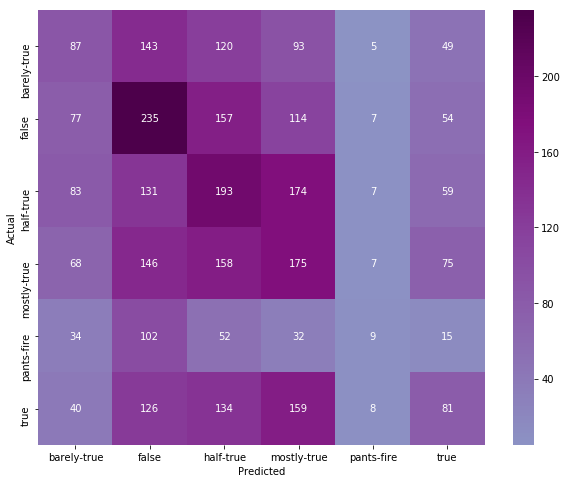

In [ ]:
predictions = search.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(y_test,predictions), search.classes_)

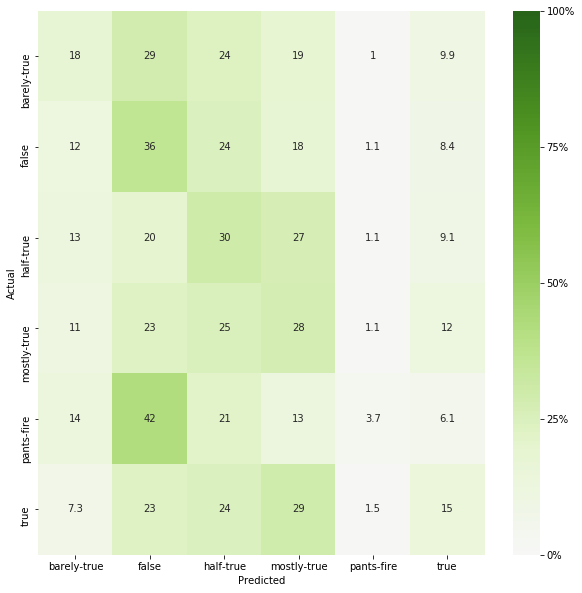

In [ ]:
confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), search.classes_)

In [ ]:
print(search.best_estimator_ )

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('colext', TextSelector(field='statement')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', inpu...nalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])


In [ ]:
search.best_score_

0.2301733652620842

In [ ]:
print(search.best_params_) 

{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)}


In [ ]:
print(search.scorer_)

{'accuracy': make_scorer(accuracy_score), 'precision_weighted': make_scorer(precision_score, pos_label=None, average=weighted), 'recall_weighted': make_scorer(recall_score, pos_label=None, average=weighted), 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted)}


## Lemmatisation of the 'statements' by giving POS (parts of speech) Tags as context

> Earlier we did stemming of the 'statements' in the LIAR dataset using NLTK porter stemmer. Now we use stemming.The aim of both is the similar that is to reduce the inflectional forms of each word into a common base or root. Lemmatization is closely related to stemming, However the difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. Here we provide POS (parts of speech tagging) as the context for lemmatisation. Stemmers are typically easier to implement and run faster but have reduced accuracy.


In [ ]:
"""WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc.
        By default it is set to Noun. Here we consider only POS tags of Noun, Adjective, Verb and Adverb. """

corpus=[]

for state in df_raw_tfid['statement']:
    
    texts=preprocess(state)
    token=nltk.word_tokenize(texts)
    corpus.append(token)

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(corpus):
    # looping through the entries and saving in the corpus
    Final_words = []
    # fitting WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag will provide the 'tag' i.e if the word is Noun(N) or Verb(V) etc.
    for word, tag in pos_tag(entry):
        # condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The processed words for each 'statement' will be store in column 'lemmatised_words in the dataframe'
    df_raw_tfid.loc[index,'Lemmatised_words'] = str(Final_words)

In [ ]:
# sample lemmatised text of the 'statements'
corpus[1:2]

[['the',
  'name',
  'frank',
  'has',
  'risen',
  'in',
  'popularity',
  'by',
  '20',
  'percent',
  'since',
  'the',
  'debut',
  'of',
  'house',
  'of',
  'cardson',
  'netflix']]

In [ ]:
# We can see that new column 'Lemmtised_words is created which stores the lemmatised words of the 'statements'
df_raw_tfid.head(2)

,index,ID,label,statement,TotalWords,Lemmatised_words,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",7,"['mccain', 'oppose', 'woman', 'right', 'choose']",abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,18,"['name', 'frank', 'rise', 'popularity', 'perce...",pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes


In [ ]:
X=df_raw_tfid['Lemmatised_words'].tolist()
y=df_raw_tfid['label']

In [ ]:
# fitting TfidfVectorizer with the lemmatised 'statements'
Encoder = LabelEncoder()
y = Encoder.fit_transform(y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df_raw_tfid['Lemmatised_words'])
X = Tfidf_vect.transform(X)

In [ ]:
# logistic regression classifier
logistic = LogisticRegression(solver='liblinear', random_state=0)

In [ ]:
# cross validation
cv_scores = cross_validate(logistic, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])



Accuracy: mean = 25.01%, sd = 0.79%, min = 23.79, max = 26.05
Precision: mean = 25.51%, sd = 1.53%, min = 23.30, max = 27.48
Recall: mean = 25.01%, sd = 0.79%, min = 23.79, max = 26.05
F1: mean = 23.91%, sd = 0.91%, min = 22.53, max = 25.06


In [ ]:
#confusion_matrix_heatmap(confusion_matrix(y_test,predictions), search.classes_)

In [ ]:
SVM_classifier=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=0)

In [ ]:
cv_scores = cross_validate(SVM_classifier, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])


Accuracy: mean = 24.31%, sd = 0.90%, min = 22.86, max = 25.27
Precision: mean = 25.19%, sd = 1.41%, min = 22.92, max = 27.04
Recall: mean = 24.31%, sd = 0.90%, min = 22.86, max = 25.27
F1: mean = 23.49%, sd = 0.92%, min = 21.97, max = 24.46


In [ ]:
XGradientBoost= XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0)

In [ ]:
cv_scores = cross_validate(XGradientBoost, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])


Accuracy: mean = 24.42%, sd = 0.65%, min = 23.55, max = 25.16
Precision: mean = 24.45%, sd = 0.64%, min = 23.55, max = 25.30
Recall: mean = 24.42%, sd = 0.65%, min = 23.55, max = 25.16
F1: mean = 22.86%, sd = 0.69%, min = 21.99, max = 23.80


## Converting the Multiclass labels into Binary class labels (Fake & True) and predicting

In [ ]:
bi_class.head(2)

,label,statement
0,True,"""McCain opposes a woman's right to choose."""
1,Fake,The name Frank has risen in popularity by 20 p...


In [ ]:
bi_class['TotalWords'] = bi_class['statement'].str.split().str.len()

In [ ]:
bi_class.head(2)

,label,statement,TotalWords
0,True,"""McCain opposes a woman's right to choose.""",7
1,Fake,The name Frank has risen in popularity by 20 p...,18


In [ ]:
X = bi_class[['statement', 'TotalWords']]

Y=  bi_class['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [ ]:

classifier_biclass = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='word',preprocessor=preprocess, tokenizer=Tokenizer, stop_words=stopwords_list,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
    ])

In [ ]:
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

Accuracy:  0.6110937986911811
              precision    recall  f1-score   support

        Fake       0.56      0.45      0.50      1373
        True       0.64      0.73      0.68      1836

   micro avg       0.61      0.61      0.61      3209
   macro avg       0.60      0.59      0.59      3209
weighted avg       0.60      0.61      0.60      3209

[[ 619  754]
 [ 494 1342]]


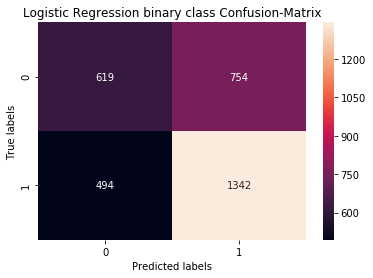

In [ ]:
matrix=confusion_matrix(y_test, predictions) # getting the results of confusion matrix from the classification.
sns.heatmap(matrix, annot = True,fmt='g')       # printing the matrix
plt.title('Logistic Regression binary class Confusion-Matrix')
plt.ylabel('True labels')
plt.xlabel('Predicted labels');

In [ ]:
classifier_biclass.set_params(clf=GaussianNB())
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

Accuracy:  0.5712059831723278
              precision    recall  f1-score   support

        Fake       0.50      0.56      0.53      1373
        True       0.64      0.58      0.61      1836

   micro avg       0.57      0.57      0.57      3209
   macro avg       0.57      0.57      0.57      3209
weighted avg       0.58      0.57      0.57      3209

[[ 773  600]
 [ 776 1060]]


In [ ]:
classifier.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

Accuracy:  0.5715176067310689
              precision    recall  f1-score   support

        Fake       0.50      0.57      0.53      1373
        True       0.64      0.57      0.60      1836

   micro avg       0.57      0.57      0.57      3209
   macro avg       0.57      0.57      0.57      3209
weighted avg       0.58      0.57      0.57      3209

[[ 784  589]
 [ 786 1050]]


In [ ]:
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
classifier.set_params(clf=decision_tree)
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

Accuracy:  0.5702711124961047
              precision    recall  f1-score   support

        Fake       0.50      0.56      0.53      1373
        True       0.64      0.58      0.61      1836

   micro avg       0.57      0.57      0.57      3209
   macro avg       0.57      0.57      0.57      3209
weighted avg       0.58      0.57      0.57      3209

[[ 770  603]
 [ 776 1060]]


In [ ]:
classifier.set_params(clf=RandomForestClassifier())
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

Accuracy:  0.5761919601121844
              precision    recall  f1-score   support

        Fake       0.50      0.57      0.54      1373
        True       0.64      0.58      0.61      1836

   micro avg       0.58      0.58      0.58      3209
   macro avg       0.57      0.58      0.57      3209
weighted avg       0.58      0.58      0.58      3209

[[ 787  586]
 [ 774 1062]]


In [ ]:
classifier.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

Accuracy:  0.5780617014646308
              precision    recall  f1-score   support

        Fake       0.51      0.57      0.54      1373
        True       0.64      0.59      0.61      1836

   micro avg       0.58      0.58      0.58      3209
   macro avg       0.58      0.58      0.57      3209
weighted avg       0.59      0.58      0.58      3209

[[ 779  594]
 [ 760 1076]]
